# Precision in Forecasting Medical Insurance Costs: Advanced Modeling and Analytics

In this guided project, we'll be working with the [Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle. This dataset includes details about individual medical insurance bills, such as the patient's personal and demographic information. Our goal in this regression task is to understand how these various factors are connected to **the total medical cost**. By doing this, we aim to create an effective predictive model for estimating medical expenses. This prediction is valuable for hospitals as it helps them forecast their revenue and plan for the healthcare needs of their patients.

Below is an overview of the dataset:

- ```age```: age of primary beneficiary.

- ```sex```: insurance contractor gender, female, male.

- ```bmi```: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9.

- ```children```: Number of children covered by health insurance / Number of dependents.

- ```smoker```: Smoking or not.

- ```region```: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- ```charges```: Individual medical costs billed by health insurance. 

In [1]:
# Import Necessary Libraries

import pandas as pd              # Data manipulation
import numpy as np               # Numeric operations
import seaborn as sns            # Data visualization
import matplotlib.pyplot as plt  # Plotting
from scipy.stats import boxcox    # Statistical transformation
from sklearn.linear_model import LinearRegression  # Linear regression
from sklearn.metrics import mean_squared_error, r2_score  # Performance metrics
from sklearn.model_selection import train_test_split    # Data splitting

In [2]:
# Load in the insurance dataset
insurance = pd.read_csv("insurance.csv")

# Exploring The Dataset

We'll begin by exploring the dataset, which involves understanding the data types of each column, checking for missing or unreasonable values, and reviewing the dataset's statistical information

In [3]:
# Display information about the dataset's columns and data types
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Key findings from the dataset include:

- The data consists of 1,338 rows and 7 columns. 
- All entries are non-null, indicating that there are no missing values. 
- Among these columns, ```age```, ```bmi```, ```children```, and ```charges``` contain numerical values, while ```sex```, ```smoker```, and ```region``` contain categorical values.
- ```charges``` is the outcome variable, and the rest are potential predictors. 

Now, let's take a look at the first few rows of the dataset for an overview.

In [4]:
# Display the first few rows of dataset
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Let's examine the statistics for the numerical columns.

In [5]:
# Generate descriptive statistics for the dataset
insurance.describe().round(2)

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


Key insights:

- The outcome ```charges``` column contains values that fall within expected ranges, with a mean medical cost of $\$13,270.42$, a minimum of $\$1,121.87$, and a maximum of $\$63,770.43$. 

- All values appear reasonable since ```age```, ```bmi```, ```children```, and ```charges``` cannot logically be negative.

# The Outcome Variable
To get a clearer understanding of the distribution of the outcome variable, let's create a histogram.

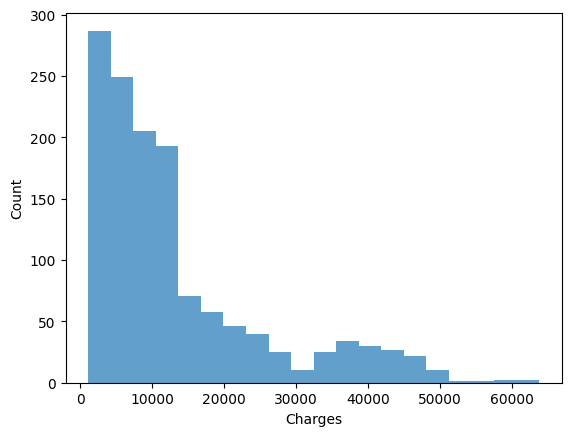

In [6]:
# Create a histogram of 'charges' with 20 bins
plt.hist(insurance['charges'], bins=20, alpha=0.7)

# Add labels to the axes
plt.xlabel('Charges')
plt.ylabel('Count')

# Display the plot
plt.show()

The ```charges``` column is highly skewed to the right, indicating there are extreme values at the higher end. This suggests that the errors in the model are unlikely to be centered at zero. In regression analyses, these extreme values may influence on the estimated coefficients and lead to deviations in the residuals, which affects the assumption of constant variance.

# Transformations of the Outcome

In such situations, we can make adjustments to the outcome variable to mitigate the influence of extreme values. Two commonly used methods for achieving this are:

- **Log Transformation**: This method is helpful when the outcome covers a wide range of values or includes extreme data points. By applying a log transformation, we can reduce the impact of extreme values, ensuring that the model's residuals exhibit consistent variability.

- **Box-Cox Transformation**: It involves reshaping the distribution of the outcome variable to approximate a Gaussian (bell-shaped) curve. This transformation supports the assumption of constant variance in residuals. It's important to note that the Box-Cox transformation requires positive values, which is applicable to our dataset since the ```charges``` column does not contain negative values.

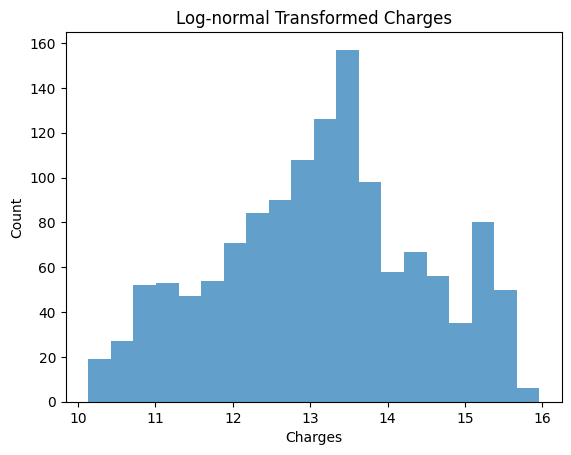

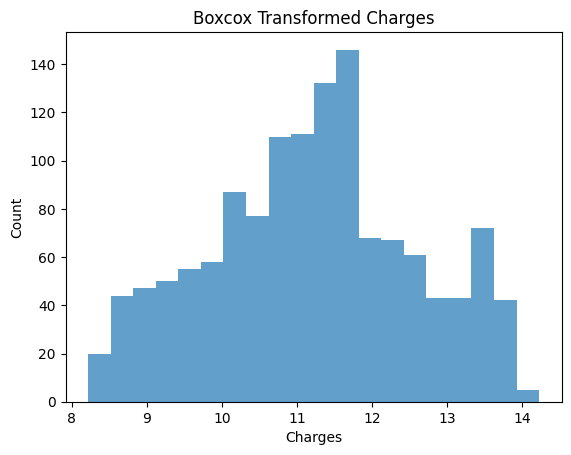

In [7]:
# Apply transformations
insurance['log_normal_charges'] = np.log2(insurance['charges'])
transformed_data, boxcox_lambda = boxcox(insurance['charges'])
insurance['boxcox_charges'] = transformed_data

# List of transformations and corresponding column names
transformations = ['log_normal_charges', 'boxcox_charges']
titles = ['Log-normal Transformed Charges', 'Boxcox Transformed Charges']

# Plot histograms for each transformation
for transformation, title in zip(transformations, titles):
    plt.hist(insurance[transformation], bins=20, alpha=0.7)
    plt.title(title)
    plt.xlabel('Charges')
    plt.ylabel('Count')
    plt.show()

The ```log-transformed charges``` seem more centered compared to the ```Box-Cox-transformed charges```. Therefore, we select the ```log-transformed charges``` for our model because this choice is more likely to result in unbiased errors.

# Feature Selection
The idea behind feature selection is to improve a model's predictive performance by choosing predictors that have a strong correlation with the outcome. High correlation between a predictor and the outcome implies that changes in the predictor can reliably predict changes in the outcome. If a predictor lacks correlation with the outcome, changes in that predictor provide limited information.

Now, let's see how the values in the categorical columns are related to the ```log-transformed charges```.

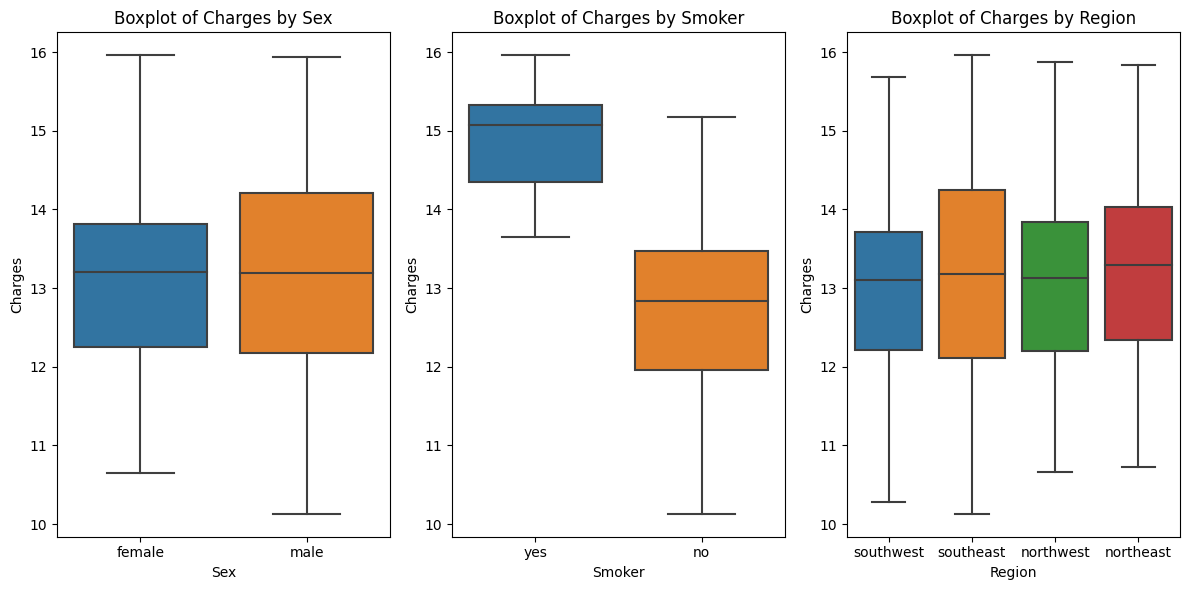

In [8]:
# List of categorical columns
categorical_columns = ['sex', 'smoker', 'region']

# Create boxplots for categorical columns
plt.figure(figsize=(12, 6))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(1, 3, i)
    
    # Create a boxplot for the current categorical column
    sns.boxplot(x=col, y='log_normal_charges', data=insurance)
    
    # Add title and labels
    plt.title(f'Boxplot of Charges by {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Charges')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Here are the analyses based on the plots:

- ```Sex```: The range of charges for females is narrower than that for males, but there are no significant differences between the distributions of males and females.

- ```Smoker```: Patients who smoke have significantly higher insurance costs than those who don't smoke, which makes sense.

- ```Region```: There don't seem to be many appreciable differences between regions.

Therefore, we will choose ```smoker``` as one of the predictors. We will convert the ```smoker``` column to numerical variables and then combine it with the numerical columns to determine which variables are more correlated with the ```log-transformed charges```.

In [9]:
# Create a copy of the insurance dataset
insurance_modif = insurance.copy()

# Convert 'smoker' column to numerical (1=yes, 0=no)
insurance_modif['smoker'] = insurance_modif['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

# Display information about the 'smoker' column in the modified dataset
print("\nInformation about 'smoker' column:")
print(insurance_modif['smoker'].head())


Information about 'smoker' column:
0    1
1    0
2    0
3    0
4    0
Name: smoker, dtype: int64


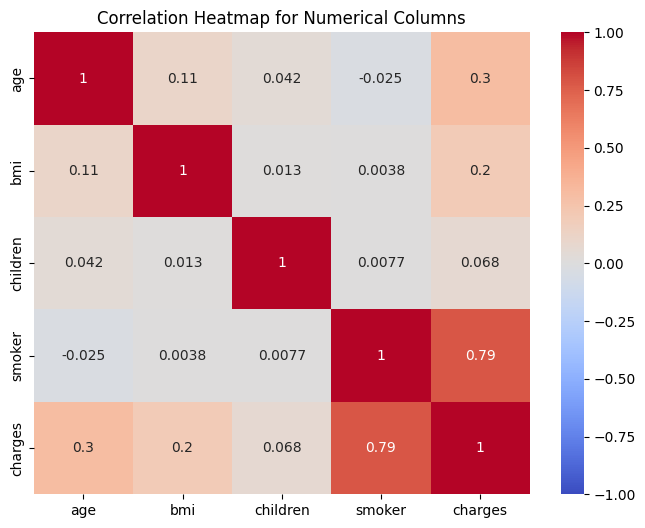

In [10]:
# List of numerical columns
numerical_columns = ['age', 'bmi', 'children','smoker', 'charges']

# Compute the correlation matrix
correlation_matrix = insurance_modif[numerical_columns].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

# Add a title to the heatmap
plt.title("Correlation Heatmap for Numerical Columns")

# Display the heatmap
plt.show()

Based on the heatmap:
- ```smoker``` has a significantly high correlation with ```charges```, which is expected, with a correlated value of 79%. 
- ```Age``` and ```bmi``` also have relatively high correlations with ```charges```, with correlated values of 30% and 20%, respectively.
- the number of children has a 6.8% correlation. 

As a result, we will choose ```age```, ```bmi``` ,and ```smoker``` as part of the predictors.

# Dividing The Data
We split the insurance dataset into two parts:

- Training set: This is used to figure out the regression coefficients.
- Test set: It's reserved for checking how well the model predicts new data.

We use the training set to calculate the coefficients for our predictors. We avoid using the test dataset for this purpose because it should represent new, unseen data. The model isn't designed for it, so any prediction errors in the test set help us understand how well the model can make predictions

# Build The Model
The function will divide the dataset into training and testing sets, with a test size of 20 percent of the dataset and a fixed random state of 100 for reproducibility.

We will iterate through all types of charges to analyze the regression coefficients and coefficient of determination.

In [11]:
# Create an empty list to store results
results = []

# List of types of charges
charges = ['charges', 'log_normal_charges', 'boxcox_charges']

for charge in charges:
    # Prepare features and target
    X = insurance_modif[['age', 'bmi', 'smoker']]
    y = insurance_modif[charge]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

    # Initialize and fit the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    train_predictions = model.predict(X_train)
    
    # Calculate Root Mean Squared Error (RMSE) and R-squared (R2)
    train_mse = mean_squared_error(y_train, train_predictions)
    R2 = r2_score(y_train, train_predictions)

    # Store results in the list
    results.append([charge, train_mse, R2, model.coef_])

    # Print RMSE, R2, and coefficients
    print(f'Charge Type: {charge}')
    print(f'Training MSE: {train_mse:.7f}')
    print(f'R2: {R2:.2f}')
    print(f'Intercept: {model.intercept_}')
    coefficient_table = pd.DataFrame(data=model.coef_, index=['age', 'bmi', 'smoker'], columns=['Coefficient'])
    coefficient_table = coefficient_table.round(2)
    print(coefficient_table)
    print()


Charge Type: charges
Training MSE: 38146209.6920584
R2: 0.73
Intercept: -11170.514453590085
        Coefficient
age          266.11
bmi          299.34
smoker     23499.67

Charge Type: log_normal_charges
Training MSE: 0.4565750
R2: 0.74
Intercept: 10.192207334414118
        Coefficient
age            0.05
bmi            0.01
smoker         2.20

Charge Type: boxcox_charges
Training MSE: 0.4765452
R2: 0.75
Intercept: 8.178855093054636
        Coefficient
age            0.05
bmi            0.02
smoker         2.30



The model for ```charges``` has a significantly negative intercept of around -11,171. This implies that even when factors like ```age```, ```bmi```, and ```smoker``` are set to high values, the predicted medical cost will be negative, which is illogical. Additionally, its Mean Squared Error (MSE) on the training set is quite high, indicating poor predictive performance. Therefore, this confirms what we mentioned earlier: extreme values in the outcome variable don't provide meaningful and accurate predictions and lead to poor performance.

In contrast, all values in the model of ```log_normal_charges``` and ```boxcox_charges``` appear reasonable, including intercepts, coefficients, and coefficients of determination. Therefore, going forward, our focus will be on these two types of transformations only.

# Residual Diagnostics
Now, we'll plot a graph to see whether the residuals (Observed Value - Predicted Value) exhibit trends with the model predictions. This helps us assess how well the model's predictions align with the true data points. A well-behaved scatter plot should show residuals scattered randomly around the horizontal axis without any noticeable trends. Patterns in the scatter plot could indicate that the model is not capturing certain relationships or that assumptions of linear regression might be violated.

          Charge Type  R-squared
0  log_normal_charges   0.742336
1      boxcox_charges   0.746283


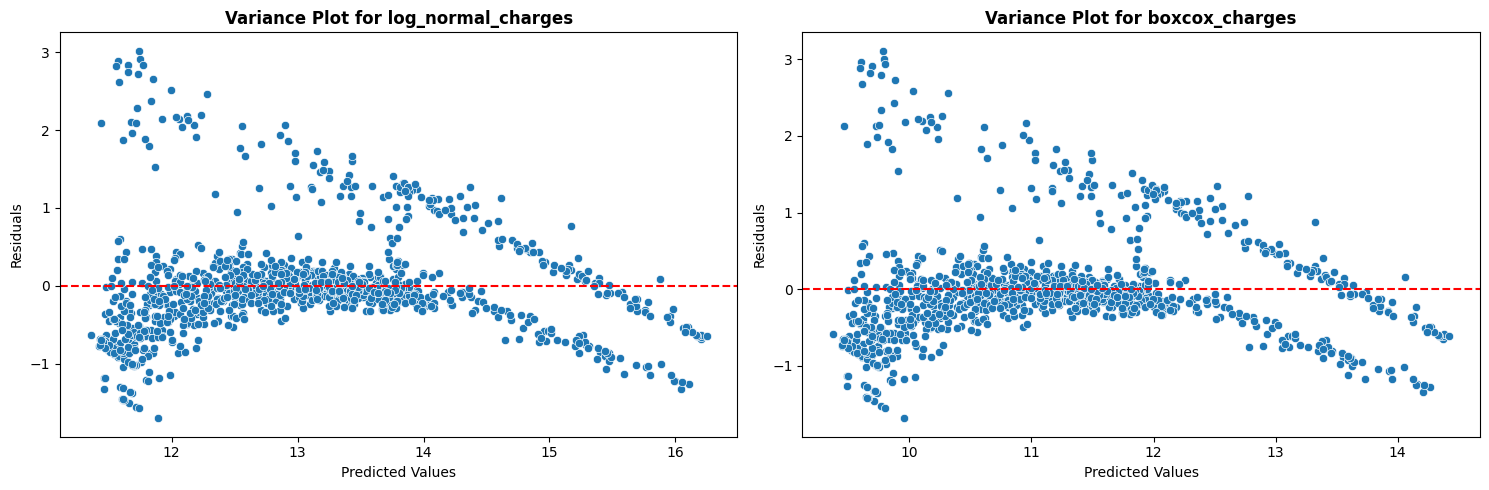

In [12]:
# List of types of charges
updated_charges = ['log_normal_charges', 'boxcox_charges']

# Create an empty list to store results
results = []

# Create a subplot grid for the variance plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Loop through each charge type
for i, charge in enumerate(updated_charges):
    # Prepare features and target
    X = insurance_modif[['age', 'bmi', 'smoker']]
    y = insurance_modif[charge]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

    # Initialize and fit the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_train)

    # Calculate Root Mean Squared Error (RMSE) and R-squared
    train_rmse = mean_squared_error(y_train, predictions, squared=False)
    R2 = r2_score(y_train, predictions)

    # Calculate residuals
    residuals = y_train - predictions

    # Plot Variance
    ax = axes[i]
    sns.scatterplot(x=predictions, y=residuals, ax=ax)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_title(f'Variance Plot for {charge}', weight='bold')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')

    # Store results in the list
    results.append([charge, R2])

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Charge Type', 'R-squared'])

# Adjust the layout to prevent overlapping titles
plt.tight_layout()

# Print the DataFrame
print(results_df)



Key observations:

- The residuals are not centered around the mean, which violates the assumption that Mean(Errors) = 0.

- As fitted values increase, the residuals tend to trend downward. While this doesn't necessarily render the model predictions unusable, it does raise questions about the linear regression assumptions.

- The residuals do not exhibit constant variation or a consistent band, which violates the assumption of the constancy of variance of error terms.

The coefficient of determination score is similar for both charges. However, we will further evaluate them using their mean squared error (MSE) based on the testing set.




In [13]:
# Create a list to store results
results = []

# Loop through each updated charge type
for charge in updated_charges:
    # Prepare features and target
    X = insurance_modif[['age', 'bmi', 'smoker']]
    y = insurance_modif[charge]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

    # Initialize and fit the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on the training and test data
    train_predictions = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Calculate Root Mean Squared Error (RMSE) on the training set
    train_rmse = mean_squared_error(y_train, train_predictions)

    # Calculate Mean Squared Error (MSE) on the test set
    test_mse = mean_squared_error(y_test, test_pred)

    # Calculate MSE in exponential scale
    test_mse_exp = np.exp(test_mse)

    # Calculate R-squared on the training set
    r2 = r2_score(y_train, train_predictions)

    # Append results to the list
    results.append([charge, round(train_rmse, 2), r2, round(test_mse, 2), round(test_mse_exp, 2)])

# Create a DataFrame to store the results
results_df = pd.DataFrame(results, columns=['Charge Type', 'MSE on Train Set', 'R-squared', 'MSE on Test Set', 'MSE on Test Set (Exponential Scale)'])

# Print the results DataFrame
print(results_df)


          Charge Type  MSE on Train Set  R-squared  MSE on Test Set  \
0  log_normal_charges              0.46   0.742336             0.42   
1      boxcox_charges              0.48   0.746283             0.44   

   MSE on Test Set (Exponential Scale)  
0                                 1.53  
1                                 1.55  


The coefficient of determination score for both is close. However, ```log_normal_charge``` has a lower Mean Squared Error (MSE) on the test set, indicating better predictive performance. Therefore, we will choose ```log_normal_charge``` over ```boxcox_charges``` for our model.

# Interpreting The Model

In [14]:
# Select features and target
X = insurance_modif[['age', 'bmi', 'smoker']]
y = insurance_modif['log_normal_charges']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate Root Mean Squared Error (RMSE) on the training set
train_predictions = model.predict(X_train)
train_rmse = mean_squared_error(y_train, train_predictions,)

# Calculate Mean Squared Error (MSE) on the test set
test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, test_pred)

# Get coefficient and intercept of the model
coefficient = model.coef_
intercept = model.intercept_

# Print coefficient, intercept, train_rmse, and test_mse
print("Coefficients:", coefficient.round(2))
print("Intercept:", intercept.round(2))
print("Train RMSE:", train_rmse.round(2))
print("Test MSE:", test_mse.round(2))



Coefficients: [0.05 0.01 2.2 ]
Intercept: 10.19
Train RMSE: 0.46
Test MSE: 0.42


# Final Model Evaluation

- As a year increases, the cost will go up by 5%, keeping ```bmi``` and ```smoker``` constant.
- As ```bmi``` increases by 1 unite, the cost will go up by 1%, keeping ```age``` and ```smoker``` constant.
- If the individual is smoking, the cost will go up by 220%, keeping ```age``` and ```bmi``` constant.

- The intercept of the model is 10.19, it indicate that the average medical cost is 10.19 when all  predictors ```age```,```bmi```, and ```smoker``` are 0. However, it doesn't provide meaningful insight here since ```age``` and ```bmi``` are unlikely to 0 in reality.


# Conclusions

The model's performance was evaluated using Mean Squared Error (MSE) on both the test and training datasets. The test MSE, approximately 0.42, which is lower than the training MSE, suggests that the model's predictions reasonably align with the true data points, indicating good generalization to unseen data. This indicates that the model is a reliable tool for estimating medical insurance charges in most cases.

However, it's worth noting that the model exhibits limitations in predicting extremely high charges. The residuals analysis reveals that the model tends to predict lower costs for individuals who were actually charged significantly higher amounts. In such cases, the model's predictions appear conservative.

To address these limitations and enhance the model's accuracy, especially for exceptionally high charges, we may consider incorporating more complex terms in the regression. This could involve exploring interactions or quadratic terms to capture nonlinear relationships within the data. By doing so, we aim to improve the model's overall performance and its ability to provide more accurate predictions, even for cases with unusually high medical charges.